#**Import Library**

In [1]:
# !pip install tensorflow
# !pip install pandas
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install pathlib2

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.6.2.post1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.2.0
cachetools                   5.5.0
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
chex                         0.1.87
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.8
decorator                    5.1.1
defusedxml                   0.7.1
etils                        1.10.0
executing                

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import zipfile
import shutil
import random
import shutil
import pathlib
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from shutil import copyfile

#**Load Data from Drive**

In [4]:
import zipfile

file_dataset = 'coffe_disease_datasets/coffe_disease_datasets.zip'
zipdata = zipfile.ZipFile(file_dataset, 'r')
zipdata.extractall('dataset')
zipdata.close()

#**Data Exploration**

In [5]:
directory1=os.listdir('./')
print(directory1)

['.ipynb_checkpoints', 'Accuracy_v1_InceptionV3.png', 'coffee-leaf-diseases', 'coffe_disease_datasets', 'Cofflyze1.ipynb', 'dataset', 'DOKUMENTASI', 'Loss_v1_InceptionV3.png', 'SaveModel1', 'Test']


In [6]:
directory1=os.listdir('./dataset')
print(directory1)

['test', 'test.csv', 'train', 'train.csv']


In [7]:
list_train_dir = os.listdir('./dataset/train/')
print(list_train_dir)
print(len(list_train_dir))

['miner', 'nodisease', 'phoma', 'rust']
4


In [8]:
training_directory='./dataset/train/'

for  item in list_train_dir:
  class_dir = os.path.join(training_directory,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

miner  :  332 images
nodisease  :  284 images
phoma  :  388 images
rust  :  260 images


miner


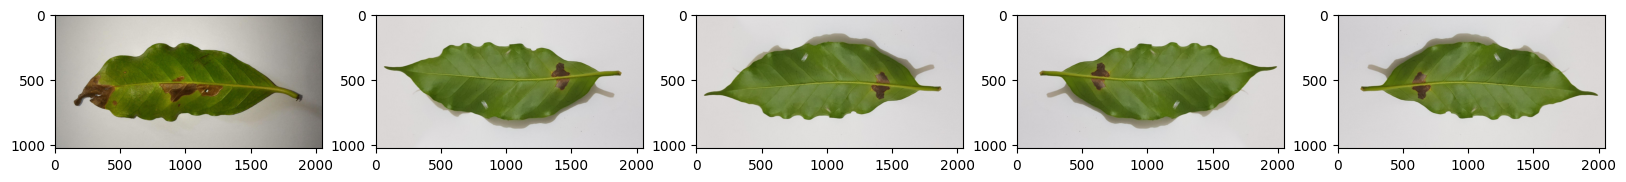

nodisease


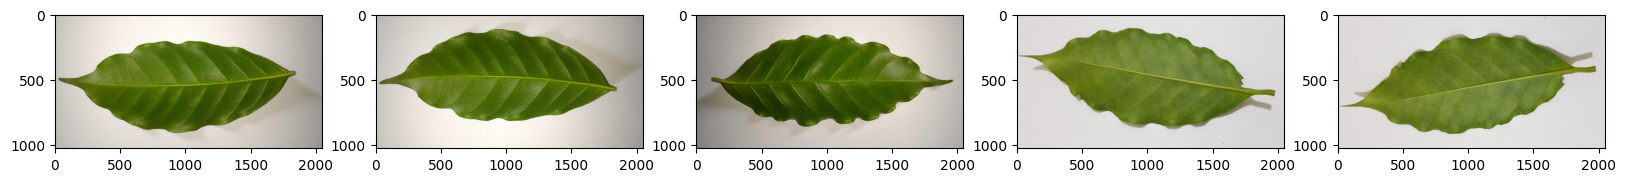

phoma


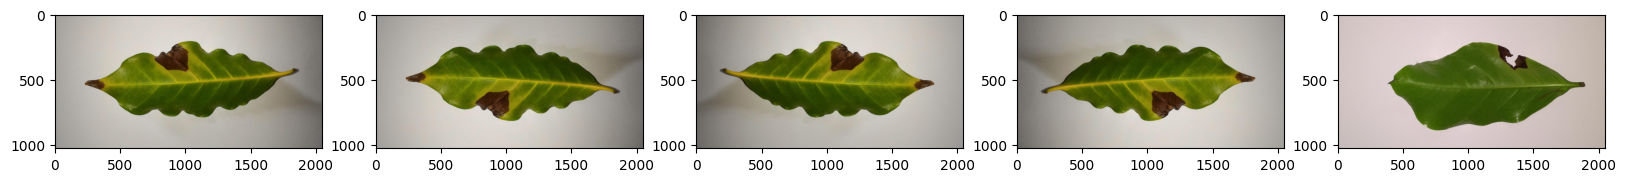

rust


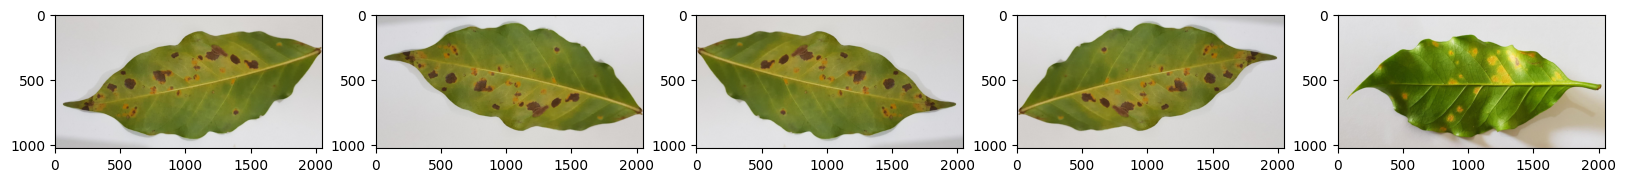

In [9]:
#checking image on directory
for  images in list_train_dir:
  print(images)
  class_dir = os.path.join(training_directory,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [10]:
list_val_dir = os.listdir('./dataset/test/')
print(list_val_dir)

['miner', 'nodisease', 'phoma', 'rust']


In [11]:
validating_directory='./dataset/test'

for  item in list_val_dir:
  class_dir = os.path.join(validating_directory,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

miner  :  128 images
nodisease  :  116 images
phoma  :  96 images
rust  :  60 images


miner


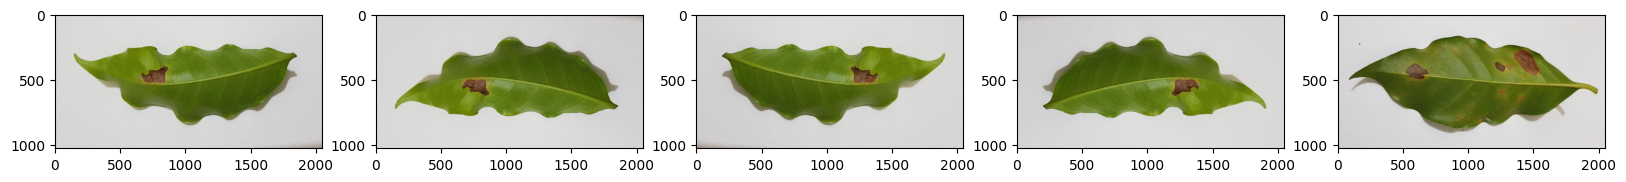

nodisease


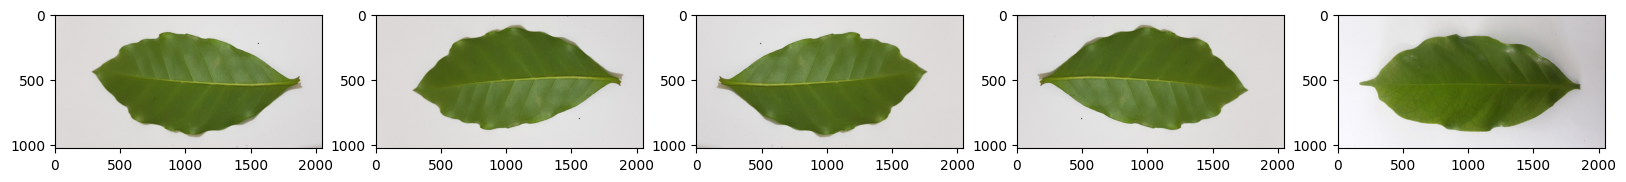

phoma


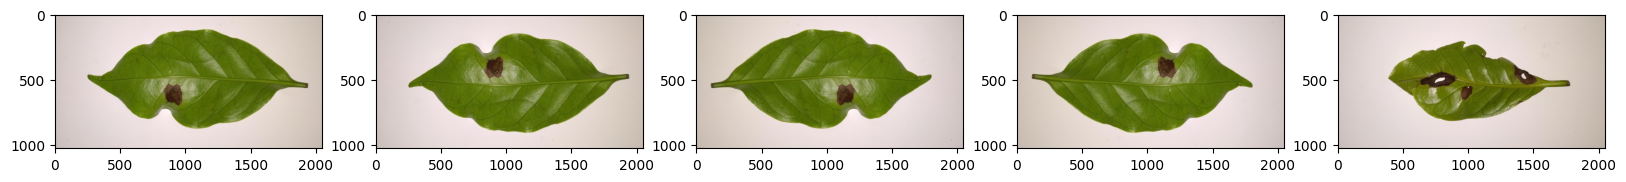

rust


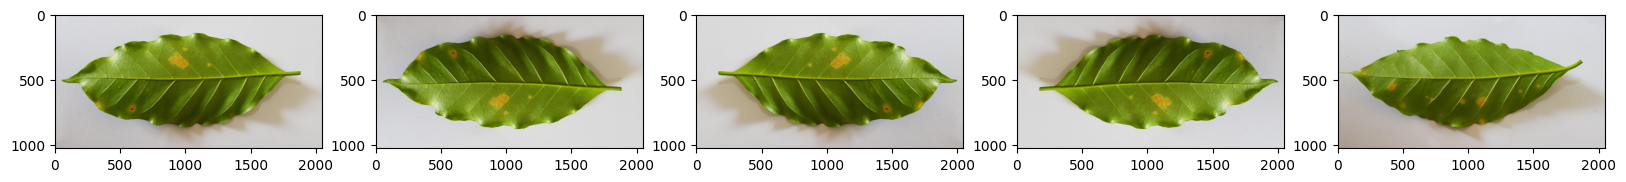

In [12]:
#checking image on directory
for  images in list_val_dir:
  print(images)
  class_dir = os.path.join(validating_directory,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

#**Preparing Image Data Generator**

In [13]:
def train_val_generators(TRAINING_DIRECTORY, VALIDATING_DIRECTORY):

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIRECTORY,
                                                      batch_size=32,
                                                      class_mode = 'categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATING_DIRECTORY,
                                                                batch_size=32,
                                                                class_mode = 'categorical',
                                                                shuffle=False,
                                                                target_size=(150, 150))
    
  return train_generator, validation_generator

In [14]:
train_generator, validation_generator = train_val_generators(training_directory, validating_directory)

Found 1264 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [15]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)
num_labels = len(labels)

print("Labels: {}".format(labels))

Labels: ['miner', 'nodisease', 'phoma', 'rust']


In [16]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

  # Change 'lr' to 'learning_rate'
  model.compile(loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

  return model

In [17]:
model = create_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 && logs.get('val_accuracy)>'):
      self.model.stop_training = True
      print("\nThe accuracy of the training set has reached > 90%!")
callbacks = myCallback()

In [19]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/20


40/40 [==============================] - 106s 3s/step - loss: 1.3893 - accuracy: 0.2896 - val_loss: 1.3726 - val_accuracy: 0.3875
Epoch 2/20
40/40 [==============================] - 71s 2s/step - loss: 1.3604 - accuracy: 0.3410 - val_loss: 1.2199 - val_accuracy: 0.4900
Epoch 3/20
40/40 [==============================] - 69s 2s/step - loss: 1.2791 - accuracy: 0.3924 - val_loss: 1.2422 - val_accuracy: 0.4200
Epoch 4/20
40/40 [==============================] - 68s 2s/step - loss: 1.1941 - accuracy: 0.4407 - val_loss: 1.0587 - val_accuracy: 0.5125
Epoch 5/20
40/40 [==============================] - 68s 2s/step - loss: 1.1267 - accuracy: 0.5158 - val_loss: 1.1429 - val_accuracy: 0.5475
Epoch 6/20
40/40 [==============================] - 68s 2s/step - loss: 0.9885 - accuracy: 0.5324 - val_loss: 0.9515 - val_accuracy: 0.5725
Epoch 7/20
40/40 [==============================] - 84s 2s/step - loss: 0.8868 - accuracy: 0.6179 - val_loss: 1.3767 - val_accuracy: 0.5775
Epoch 8/20
40/40 

In [21]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

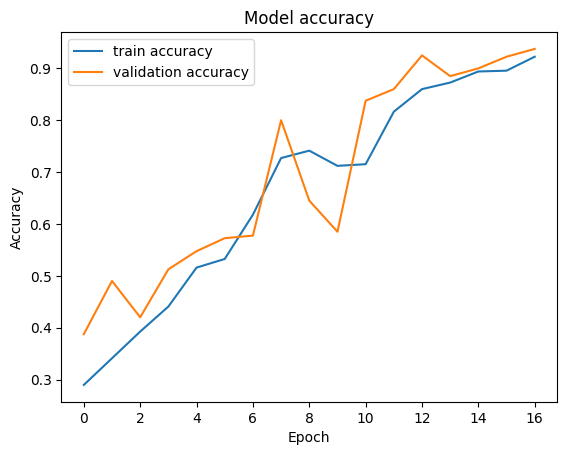

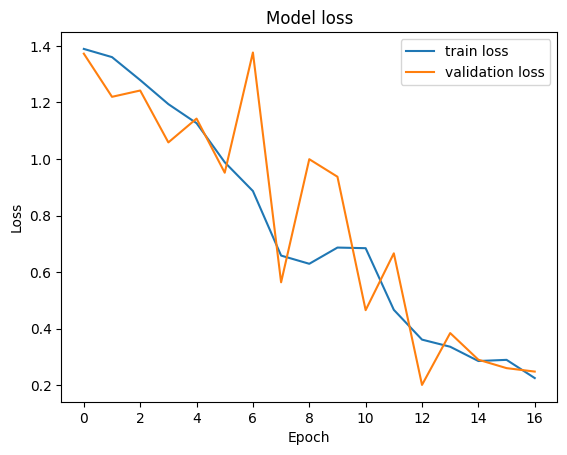

In [22]:
plot_accuracy(history)
plot_loss(history)

In [24]:
def eval_CM(y_test, y_pred, labels):
    #Generate the confusion matrix
    cf_matrix3 = confusion_matrix(y_test, y_pred)

    ax3 = sns.heatmap(cf_matrix3, annot=True, fmt='g', cmap='Blues')

    ax3.set_title('Confusion Matrix with labels\n');
    ax3.set_xlabel('\nPredicted Values')
    ax3.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax3.xaxis.set_ticklabels(labels, rotation=45)
    ax3.yaxis.set_ticklabels(labels, rotation=45)

    ## Display the visualization of the Confusion Matrix.
    return plt.show()

In [25]:
y_test = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

13/13 [==============================] - 9s 679ms/step


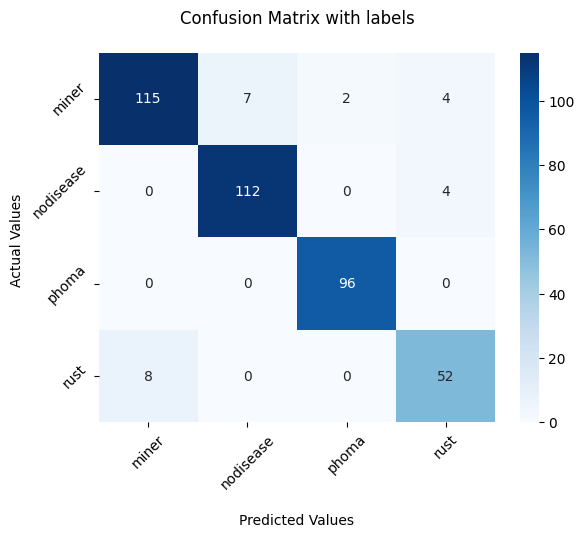

In [26]:
eval_CM(y_test, y_pred, labels)

In [27]:
score_train = model.evaluate(train_generator)
score_valid = model.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

13/13 [==============================] - 9s 667ms/step - loss: 0.2482 - accuracy: 0.9375
Accuracy (train):  0.9517405033111572
Accuracy (test): 0.9375
Loss (train):  0.15706634521484375
Loss (test): 0.2481953501701355


In [28]:
print(train_generator.class_indices)
print()
print(classification_report(y_test, y_pred))

{'miner': 0, 'nodisease': 1, 'phoma': 2, 'rust': 3}

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       128
           1       0.94      0.97      0.95       116
           2       0.98      1.00      0.99        96
           3       0.87      0.87      0.87        60

    accuracy                           0.94       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400



In [57]:
def lest_predict(model, uploaded):
    img = image.load_img(uploaded, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
    
    classes = model.predict(images, batch_size=100) # the value is not always 1 and 0 because of probabilities
    predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities
    confidence = classes[0][predicted_class_indices]
    print(classes)

    # Output results
    print(f"Predicted file: {uploaded}")
    plt.show()
    if predicted_class_indices == 0: # Miner
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Miner:")
        print("- Pengelolaan Biologis: Gunakan predator alami seperti parasitoid (Diglyphus isaea) untuk mengendalikan populasi larva.")
        print("- Pengendalian Kimia: Semprotkan insektisida berbahan aktif seperti abamectin atau spinosad secara hati-hati untuk menghindari kerusakan ekosistem.")
        print("- Pencegahan: Pangkas dan buang daun yang terinfestasi untuk mencegah penyebaran lebih lanjut.")
    elif predicted_class_indices == 1: # No Disease
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Healthy (No disease):")
        print("- Pemeliharaan: Lakukan pemangkasan rutin untuk meningkatkan ventilasi dan paparan sinar matahari.")
        print("- Pemupukan: Berikan pupuk organik atau kimia sesuai kebutuhan tanaman.")
        print("- Monitoring: Lakukan pemantauan secara berkala untuk mendeteksi penyakit atau hama sejak dini.")
    elif predicted_class_indices == 2: # Phoma
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Phoma:")
        print("- Fungisida: Aplikasikan fungisida berbahan aktif seperti chlorothalonil atau mancozeb.")
        print("- Pengelolaan Tanaman: Pastikan jarak tanam yang cukup untuk meningkatkan sirkulasi udara di antara tanaman.")
        print("- Sanitasi Kebun: Buang daun yang terinfeksi dan bakar untuk mengurangi sumber inokulum.")
        print("- Pencegahan: Hindari penyiraman di atas daun, terutama pada sore hari, untuk mengurangi kelembapan berlebih.")
    elif predicted_class_indices == 3: # Rust
        print(f"Predicted class: {labels[predicted_class_indices]}")
        print("Solution for Rust:")
        print("- Fungisida: Gunakan fungisida berbahan aktif seperti copper hydroxide atau propiconazole.")
        print("- Pengelolaan Lahan: Tanam varietas kopi yang tahan terhadap karat daun jika tersedia.")
        print("- Pemupukan: Pastikan tanaman mendapat nutrisi yang cukup, terutama nitrogen, fosfor, dan kalium, untuk meningkatkan daya tahan terhadap penyakit.")
        print("- Pembersihan Kebun: Singkirkan daun yang gugur dan terinfeksi untuk mengurangi sumber penyakit.")
    else:
        print('???')

    print(f"Confidence: {confidence:.2%}")  # Convert to percentage

1/1 [==============================] - 0s 53ms/step
[[8.4306179e-03 9.9141955e-01 1.4351565e-09 1.4982313e-04]]
Predicted file: Test/healthy3.jpg


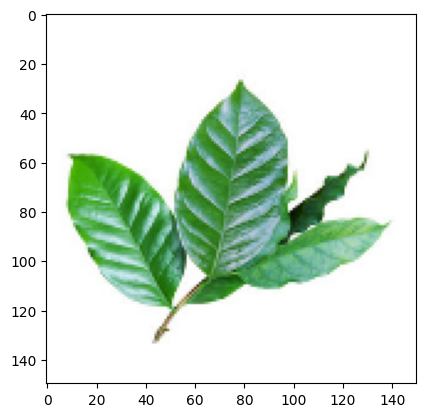

Predicted class: nodisease
Solution for Healthy (No disease):
- Pemeliharaan: Lakukan pemangkasan rutin untuk meningkatkan ventilasi dan paparan sinar matahari.
- Pemupukan: Berikan pupuk organik atau kimia sesuai kebutuhan tanaman.
- Monitoring: Lakukan pemantauan secara berkala untuk mendeteksi penyakit atau hama sejak dini.
Confidence: 99.14%


In [62]:
file_test = 'Test/healthy3.jpg'
lest_predict(model, file_test)

#**Export Model**

In [51]:
export_dir = './SaveModel1'
os.makedirs(export_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model
model.save(os.path.join(export_dir, 'model.keras'))  # or 'model.h5'

In [52]:
# Convert the model.
converte = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_mode = converte.convert()

In [53]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_mode)

13823420